# Setup

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. load the results
pareto_path = "../data/processed/procurement_optimized_pareto_front.csv"
path_weights = "../data/processed/procurement_optimized.csv"
# load data and setup style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
df_pareto = pd.read_csv(pareto_path)
df_weights = pd.read_csv(path_weights)

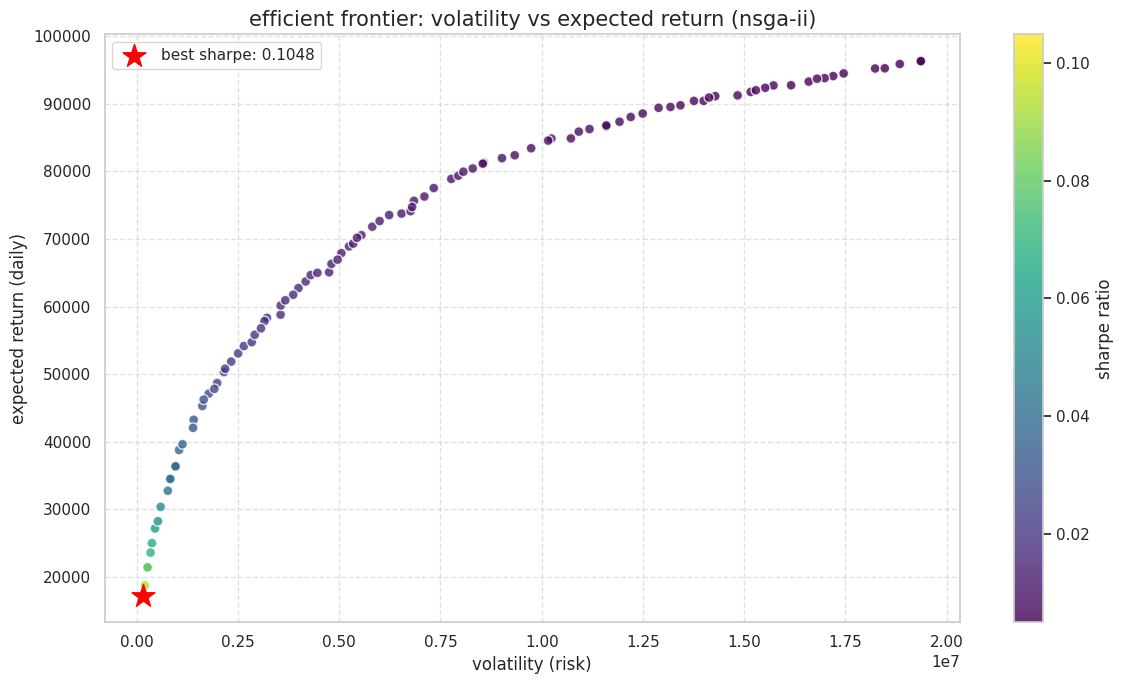

In [3]:
# 2. setup aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

# 3. plot the pareto front
# x = risk (volatility), y = reward (expected return)
scatter = plt.scatter(
    df_pareto['volatility'], 
    df_pareto['expected_return'], 
    c=df_pareto['sharpe_ratio'], 
    cmap='viridis', 
    s=50, 
    alpha=0.8,
    edgecolors='w'
)

# 4. highlight the best sharpe solution
best_sharpe = df_pareto.loc[df_pareto['sharpe_ratio'].idxmax()]
plt.scatter(
    best_sharpe['volatility'], 
    best_sharpe['expected_return'], 
    color='red', 
    marker='*', 
    s=300, 
    label=f"best sharpe: {best_sharpe['sharpe_ratio']:.4f}"
)

# 5. formatting
plt.colorbar(scatter, label='sharpe ratio')
plt.title('efficient frontier: volatility vs expected return (nsga-ii)', fontsize=15)
plt.xlabel('volatility (risk)', fontsize=12)
plt.ylabel('expected return (daily)', fontsize=12)
plt.legend(frameon=True)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Analysis of the 18 strategy

/tmp/ipykernel_100131/3444504001.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_active, x='optimal_weight', y='strategy', palette='magma')


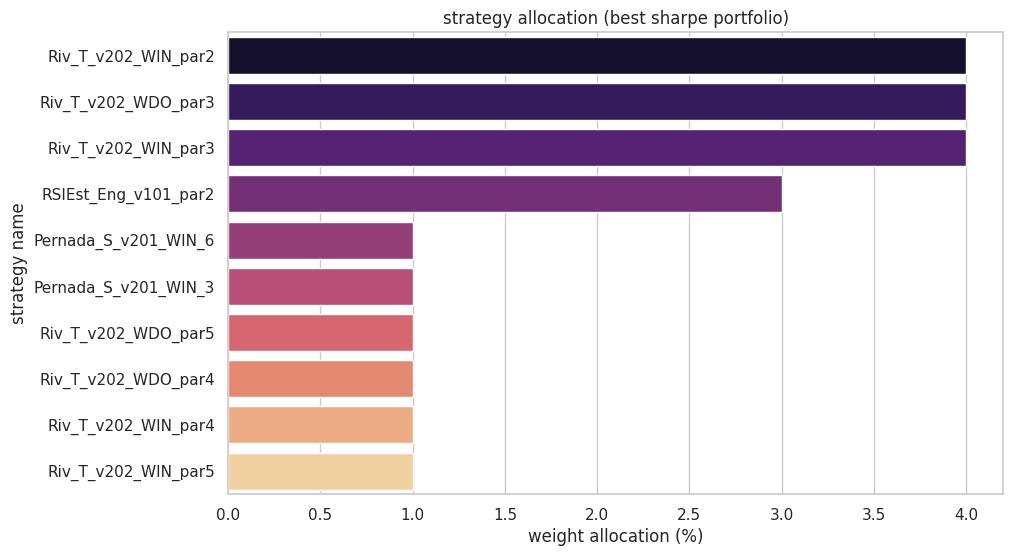

In [4]:
# load the final optimized weights
weights_path = "../data/processed/procurement_optimized.csv"
df_weights = pd.read_csv(weights_path)

# filter and plot only active strategies (weight > 1%)
df_active = df_weights[df_weights['optimal_weight'] > 0.01].sort_values('optimal_weight', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_active, x='optimal_weight', y='strategy', palette='magma')
plt.title('strategy allocation (best sharpe portfolio)')
plt.xlabel('weight allocation (%)')
plt.ylabel('strategy name')
plt.show()

# Reconstruction of the Capital Curve

debug: processing path -> ../data/raw/procurement/spreadsheets/operacoes_intermediario_otimizado.csv
debug: file mode. parsing master sheet...
success: matrix created (18 strategies)


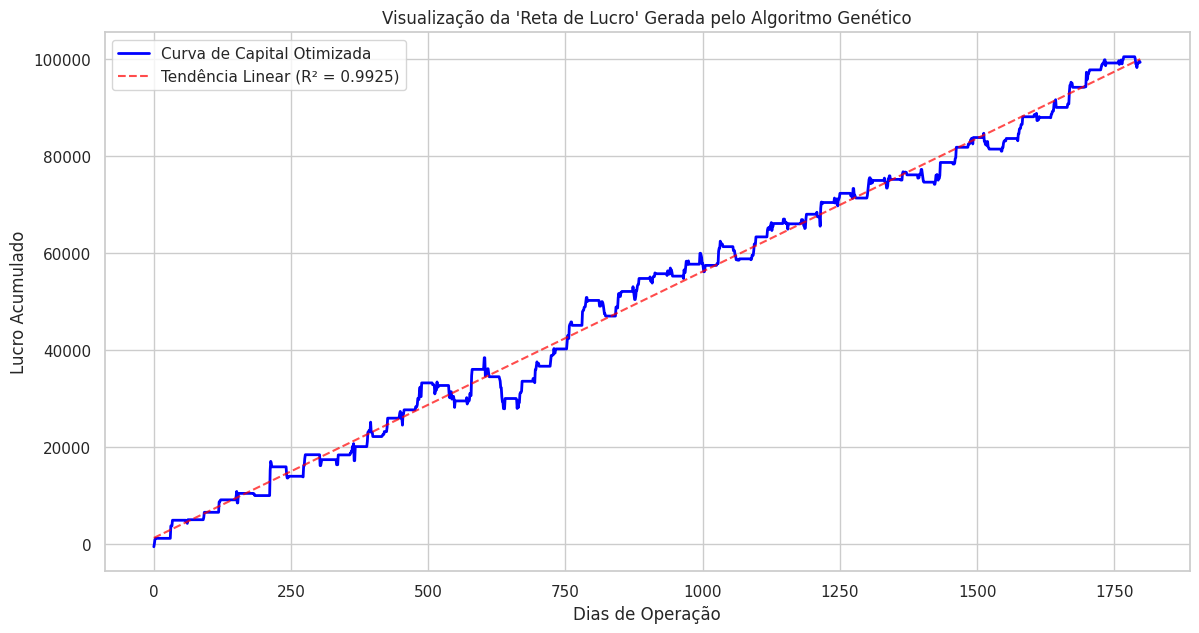

In [10]:
import sys
sys.path.append('..')
from src.data_loader import create_returns_matrix
from src.models import LinearRegression

# 1. Gerar a matriz de retornos novamente
raw_data_path = "../data/raw/procurement/spreadsheets/operacoes_intermediario_otimizado.csv"
returns_matrix = create_returns_matrix(raw_data_path)

# 2. Calcular o resultado do portfólio usando os pesos inteiros
weights_dict = dict(zip(df_weights['strategy'], df_weights['optimal_weight']))
portfolio_returns = returns_matrix.mul(pd.Series(weights_dict)).sum(axis=1)
cumulative_equity = portfolio_returns.cumsum()

# 3. Plotar
plt.figure(figsize=(14, 7))
plt.plot(cumulative_equity.values, label='Curva de Capital Otimizada', color='blue', lw=2)

# Adicionar a linha de tendência teórica para comparação
t = np.arange(len(cumulative_equity)).reshape(-1, 1)
y = cumulative_equity.values.reshape(-1, 1)
reg = LinearRegression().fit(t, y)
trend = reg.predict(t)
plt.plot(trend, color='red', linestyle='--', alpha=0.7, label=f'Tendência Linear (R² = {reg.score(t, y):.4f})')

plt.title("Visualização da 'Reta de Lucro' Gerada pelo Algoritmo Genético")
plt.ylabel("Lucro Acumulado")
plt.xlabel("Dias de Operação")
plt.legend()
plt.show()